# Assignment 2: XAI
Task: Predict the diagnosis for given x-ray images
- Task Information: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/
- Data Information: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data
<br>

Report
- Task definition
- Data description (results of data exploration)
- Description of baseline method
- Desciption of hyperparameter optimization
- Results: A table for...
    - Baseline results (repication of exisiting method)
    - Results of hyperparameter optimization/alternative approach
    - Extensive analysis of best model using XAI techniques
- Brief conclusion: Which feature respresentation/model worked the best and why

## Code

In [13]:
# # Dataset installation
# import kagglehub

# install_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", install_path)

In [14]:
# Import packages
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

### 1.0 Dataset Exploration
- Download dataset from Kaggle
- Explore dataset to under input features (images), classes (normal vs. pneumonia), and distribution of data
- Visualize sample images for both clases, along with their labels
    - Can use https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy as reference (do not just copy)

In [15]:
# Get dataset directories 
main_dir = 'chest-x-ray'

test_dir = os.path.join(main_dir, 'test')

train_dir = os.path.join(main_dir, 'train')

val_dir = os.path.join(main_dir, 'val')

# Set labels
labels=['NORMAL', 'PNEUMONIA']

# Set preferred image size for reshaping later
img_size = 150

# Function for data
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
            data.append([resized_arr, class_num])
    return data

# Load dataset
train = get_data(train_dir)
test = get_data(test_dir)
val = get_data(val_dir)

<Axes: ylabel='count'>

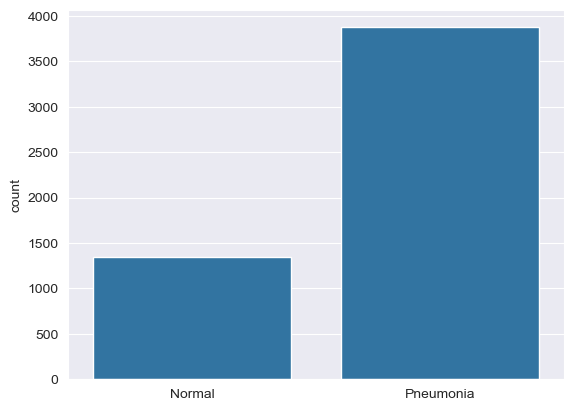

In [16]:
# Map labels to strings
l = []
for i in train:
    if i[1] == 1:
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(x=l)


Text(0.5, 1.0, 'PNEUMONIA')

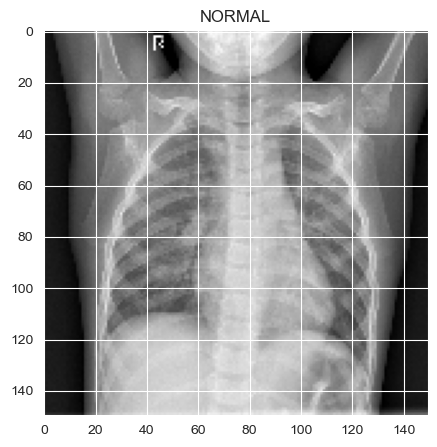

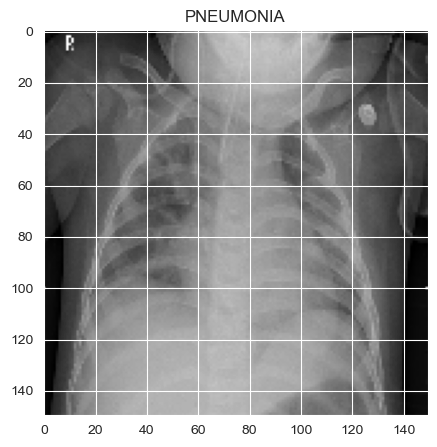

In [17]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [18]:
# Seperate features and labels
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [19]:
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

Data Augmentation:
- Mirroring/flipping
- Tilting
- Contrast/hue/saturation
- Cropping/size
Makes classifier more robust and increases dataset size 

In [20]:
# Increase data set size with data augmentation to 
#   prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### 2.0 CNN Baseline
- Use example CNN architecture provide in Kaggle code as a base. Understand role of key components like convolutional layers, pooling layers, and fully connected layers
- Train model on training dataset
- Track and report model performance metrics (accuracy, loss) during training and on the test dataset

In [22]:
def get_model(input_shape, num_filters, kernel_size, stride, dropout):
    model = Sequential()

    # LAYER 1
    model.add(Conv2D(num_filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 2
    model.add(Conv2D(num_filters * 2, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout/2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 3
    model.add(Conv2D(num_filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout/2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 4
    model.add(Conv2D(num_filters * 4, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 5
    model.add(Conv2D(num_filters * 2, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
    return model

# For grayscale images
input_shape = (img_size, img_size, 1)  

model = get_model(input_shape, num_filters=32, kernel_size=(3,3), stride=1, dropout=0.2)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.00001)
history = model.fit(x_train, y_train, batch_size=32, 
                    epochs=6, 
                    validation_data=(x_val, y_val), 
                    callbacks=[learning_rate_reduction])

# Evaluate the model on the test set
print("Loss: ", model.evaluate(x_test, y_test)[0])
print("Accuracy: ", model.evaluate(x_test, y_test)[1] * 100, "%")


c:\Users\ellae\anaconda3\envs\DS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 639ms/step - accuracy: 0.8610 - loss: 0.4500 - val_accuracy: 0.5000 - val_loss: 4.8016 - learning_rate: 0.0010
Epoch 2/6
156/163 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - accuracy: 0.9501 - loss: 0.1246

KeyboardInterrupt: 

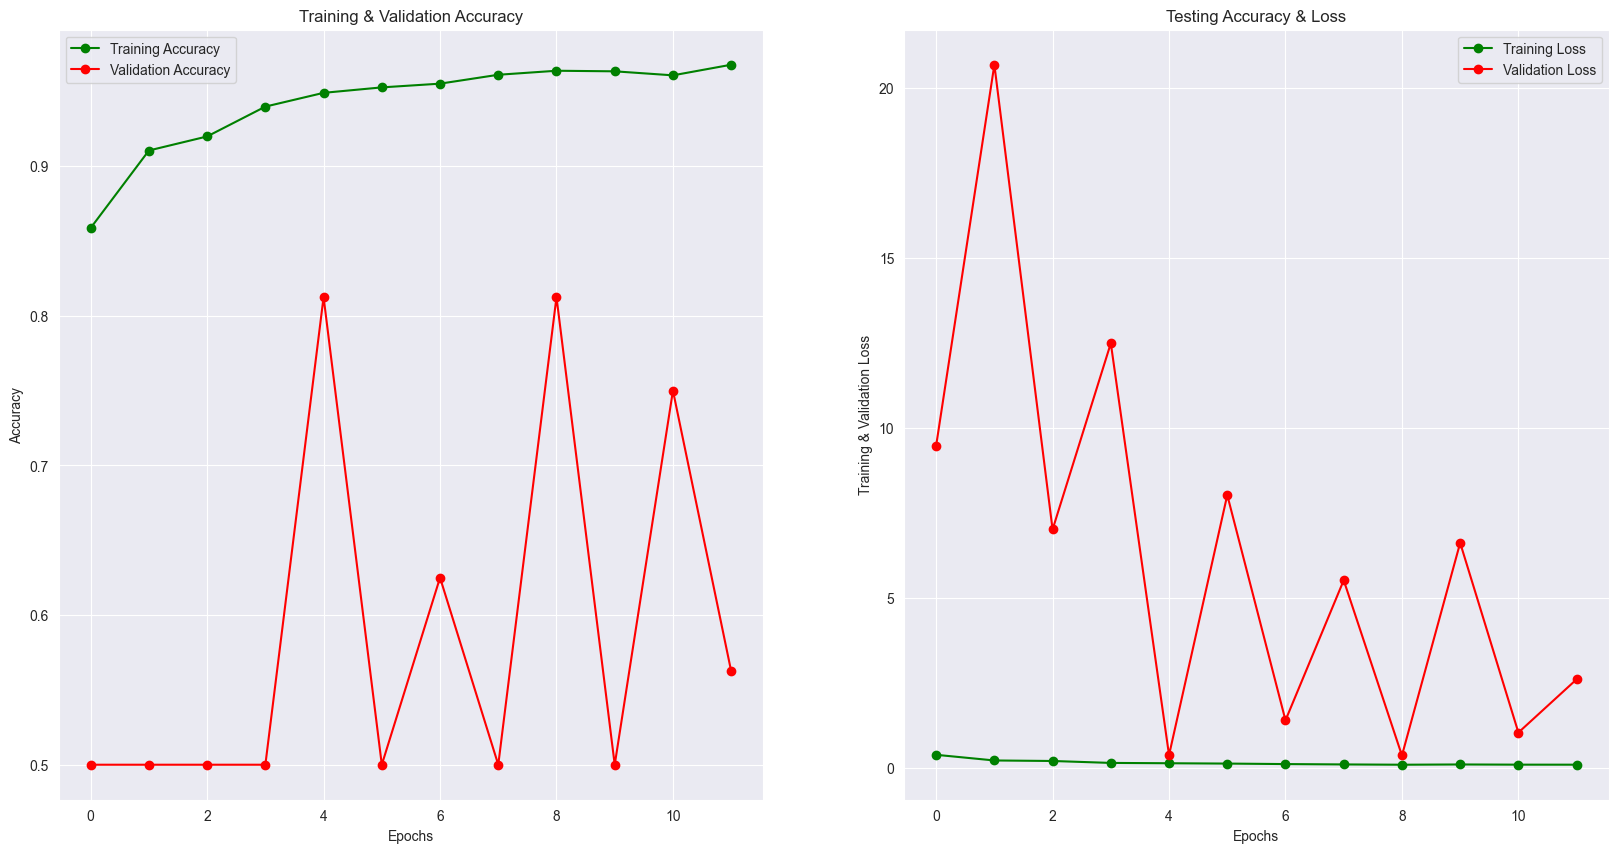

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

### 3.0 Performance Evaluation
- After training, evaluate model on test set
- Present the confusion matrix, precision, recall, and F1 score for baseline model


20/20 [==============================] - 4s 197ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.85      0.89       234
   PNEUMONIA       0.91      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624


Precision: 0.9124
Recall: 0.9615
F1 Score: 0.9363


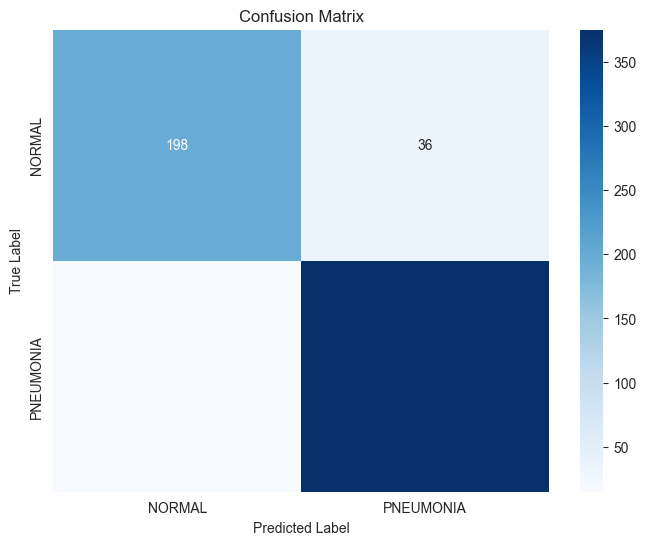


Test Accuracy: 0.9183
Test Loss: 0.2798


In [ ]:

# 1. Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

# 2. Calculate evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=labels))

precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 3. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. Calculate and display accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


### 4.0 Hyperparameter Optimization & Alternative Models
- Use an HPO method (SMAC3, Bayesian optimization, etc) to try to improve the current model; use a realistic budget (do no run experiments for more than a day)
- Try a different model (machline learning technique) for the given task, provide motivation as to why
- Present confusion matrix, precision, recall, and F1 score on train and test set for the final optimized CNN model and the alternative ML model

In [24]:
# Hyperparameter optimization
# Bayesian optimization
from bayes_opt import BayesianOptimization

# Optimize kernel, strides, dropout
# Define parameter search space
param_space = {
    'kernel': (2,5),
    'num_filters': (16, 64),
    'stride': (1,2),
    'dropout': (0.05,0.6), 
    'lr': (1e-5, 1e-2)
}

# Input shape for greyscale images
input_shape = (img_size, img_size, 1)

# Objective function
def CNN_objective(num_filters, kernel, stride, dropout, lr):
    num_filters = int(num_filters)
    kernel = int(kernel)
    stride = int(stride)

    model = get_model(input_shape, num_filters=num_filters, kernel_size=(kernel, kernel), stride=(stride, stride), dropout=dropout)
    
    optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        epochs=3,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    val_acc = history.history['val_accuracy'][-1]
    return val_acc

optimizer = BayesianOptimization(
    f = CNN_objective,
    pbounds = param_space,
    random_state = 42,
    verbose = 1
)

optimizer.maximize(init_points = 4, n_iter = 2)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |  dropout  |  kernel   |    lr     | num_fi... |  stride   |
-------------------------------------------------------------------------------------
Epoch 1/3
 86/163 ━━━━━━━━━━━━━━━━━━━━ 1:15 985ms/step - accuracy: 0.6966 - loss: 2.7947

KeyboardInterrupt: 

In [23]:
# Extract best hyperparameters and cast to correct types
best_params = optimizer.max['params']

num_filters = int(best_params['num_filters'])
kernel = int(best_params['kernel'])
stride = int(best_params['stride'])
dropout = best_params['dropout']
lr = best_params['lr']

# Rebuild and train best model
best_model = get_model(
    input_shape=input_shape,
    num_filters=num_filters,
    kernel_size=(kernel, kernel),
    stride=(stride, stride),
    dropout=dropout
)

best_model.compile(optimizer=RMSprop(learning_rate=lr),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train on full training set
best_model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)

y_pred_prob = best_model.predict(x_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Best CNN Model")
plt.show()

NameError: name 'optimizer' is not defined

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Configuration
num_classes = 2
input_shape = (img_size, img_size, 1)
patch_size = 16  # 16x16 patches
num_patches = (img_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 4  # Reduced from original to prevent overfitting
mlp_head_units = [256, 128]  # MLP head architecture

# Convert grayscale to RGB by repeating channels
x_train_rgb = tf.repeat(x_train, 3, axis=-1)
x_val_rgb = tf.repeat(x_val, 3, axis=-1)
x_test_rgb = tf.repeat(x_test, 3, axis=-1)

# Simplified ViT Implementation
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    
    # Convert to RGB
    rgb = tf.repeat(inputs, 3, axis=-1)
    
    # Reshape into patches
    patches = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding='valid'
    )(rgb)
    patches = layers.Reshape((num_patches, projection_dim))(patches)
    
    # Add learnable position embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(positions)
    x = patches + position_embedding
    
    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1
        x2 = layers.Add()([attention_output, x])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = layers.Dense(units=projection_dim * 2, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(units=projection_dim)(x3)
        x3 = layers.Dropout(0.1)(x3)
        
        # Skip connection 2
        x = layers.Add()([x3, x2])
    
    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    
    # Add MLP
    for units in mlp_head_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes)(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile model
vit_model = create_vit_classifier()
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_vit_model.h5", save_best_only=True, monitor="val_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=0.00001
    )
]

# Train the model
history = vit_model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
)

# Evaluation
test_loss, test_acc = vit_model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Generate predictions
y_pred = vit_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('ViT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Epoch 1/15
 16/163 [=>............................] - ETA: 35s - loss: 1.4826 - accuracy: 0.6484

KeyboardInterrupt: 

### 4.0 Explainable AI
- Inspect misclassification errors and use explainable AI techniques to highlight what the models are focusing on
- Feature importance with Grad-CAM (example at https://keras.io/examples/vision/grad_cam/, https://github.com/ismailuddin/gradcam-tensorflow-2, or https://deel-ai.github.io/xplique/v1.4.0/)
    - Use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts of the input images contribute most to the model's predictions
    - Choose 5-10 misclassified samples and use Grad-CAM to inspect which regions the model is focusing on
    - Interpret the results:
        - Are the activations reasonable?
        - Can it be identified why the model made incorrect predictions for chosen samples?
    - Layer-wise Relevance Propagation (LRP) (optional for bonus points)
        - Apply LRP to further analyze how different layers of network contribute to the final predictions
        - Compare insights from LRP with Grad-CAM, are there any differences in how each method highlights the important regions of the image?

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
# First, let's identify misclassified samples from the test set
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

misclassified_indices = np.where(y_pred_classes != y_test)[0]

# Select 5 random misclassified samples
np.random.seed(42)
selected_indices = np.random.choice(misclassified_indices, 5, replace=False)

# Get the last convolutional layer name from your model
# You can find this by running model.summary() and looking for the last Conv2D layer
last_conv_layer_name = "conv2d_4"  # Update this based on your model.summary()

# Modified Grad-CAM functions for your use case
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create model that maps input to last conv layer + output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient of top predicted class
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of output neuron with regard to last conv layer output
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pooled gradients
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # Heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # Normalize between 0-1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Convert grayscale to RGB for visualization
    img = np.uint8(255 * img_array)
    img = np.squeeze(img)  # Remove single-dimensional entries
    img = np.stack((img,)*3, axis=-1)  # Convert to RGB
    
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    
    # Display Grad CAM
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()



20/20 [==============================] - 4s 214ms/step



Sample 1:
True label: PNEUMONIA
Predicted label: NORMAL
Prediction confidence: 0.10


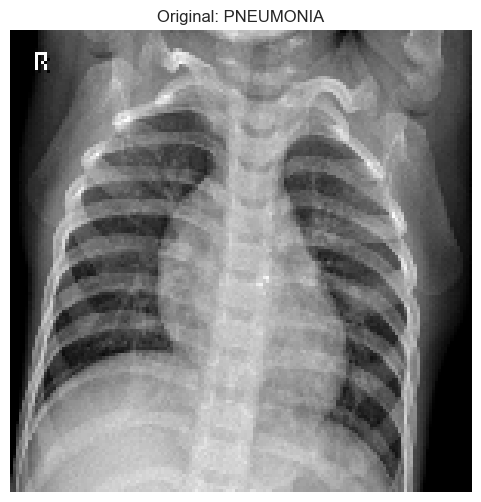

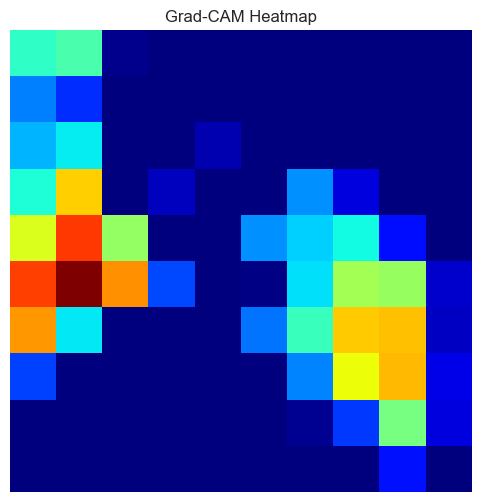

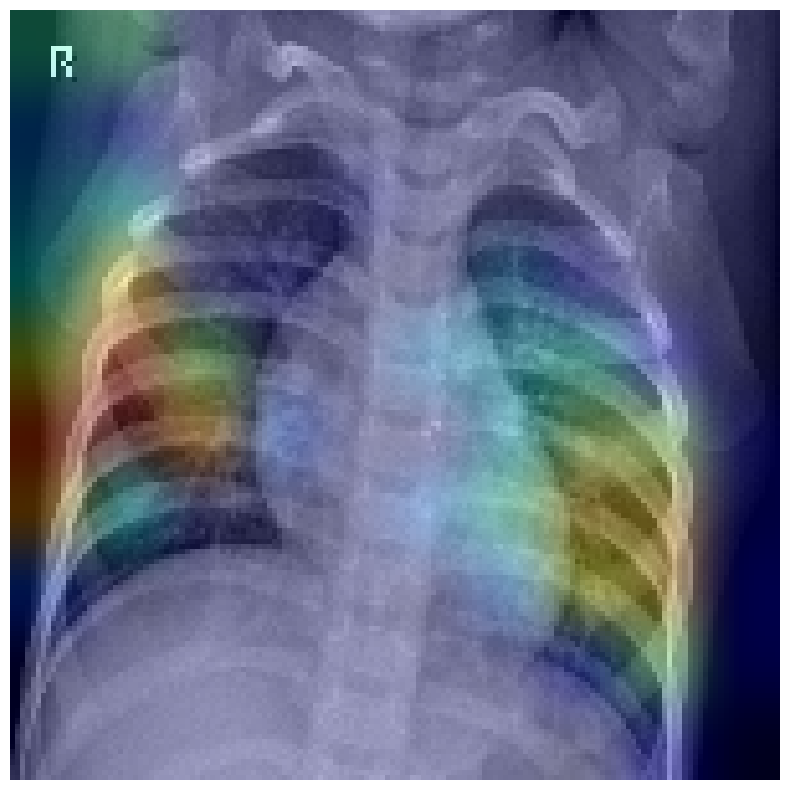


Sample 2:
True label: PNEUMONIA
Predicted label: NORMAL
Prediction confidence: 0.20


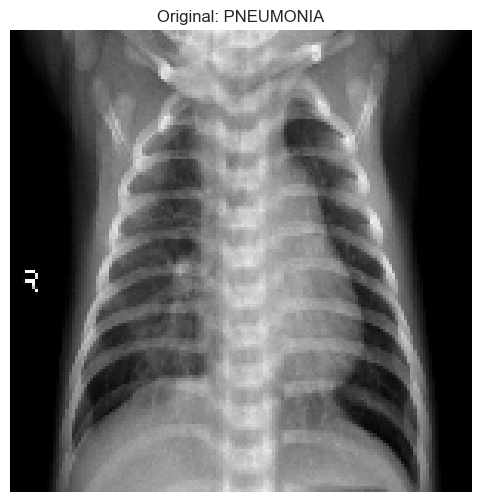

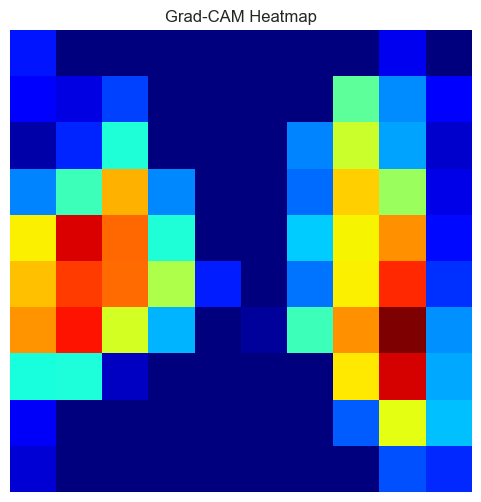

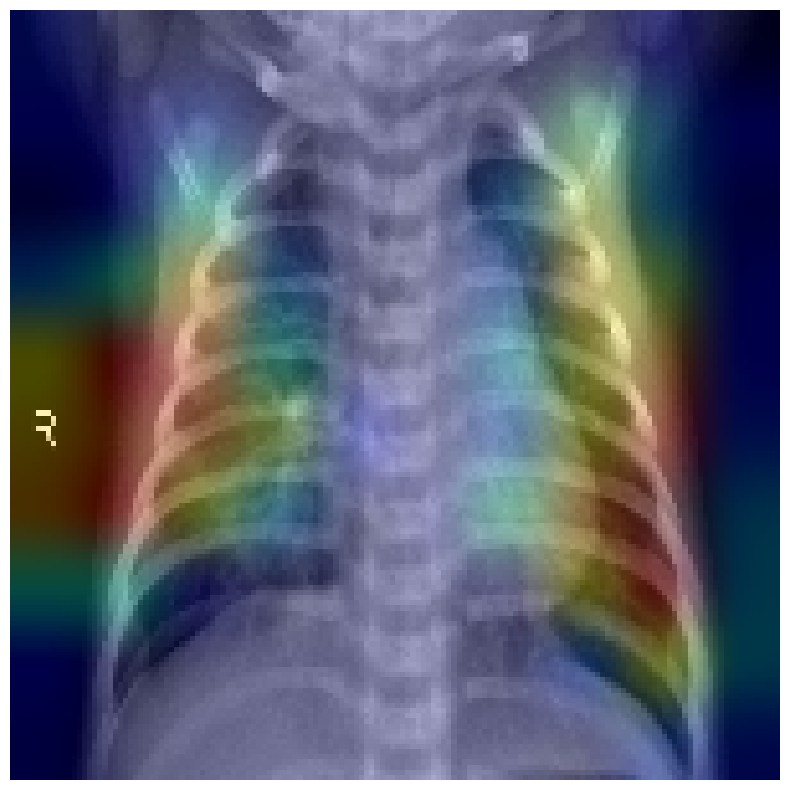


Sample 3:
True label: PNEUMONIA
Predicted label: NORMAL
Prediction confidence: 0.09


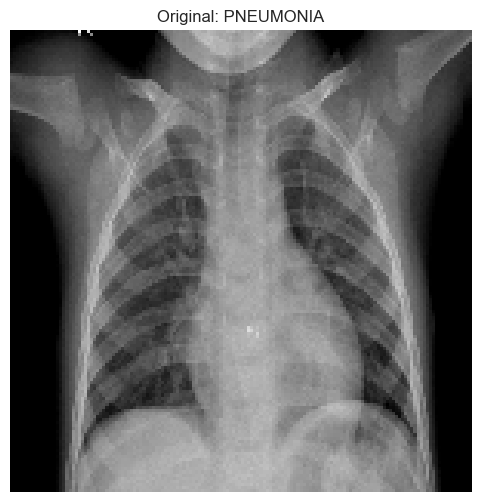

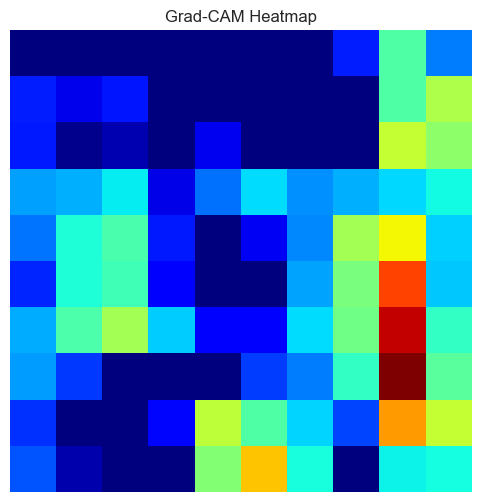

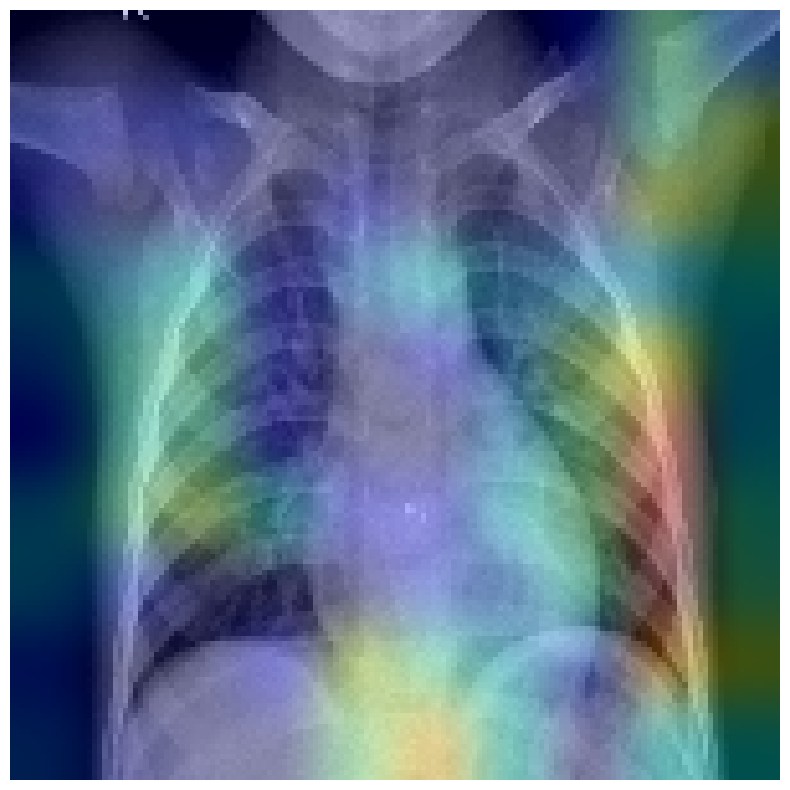


Sample 4:
True label: NORMAL
Predicted label: PNEUMONIA
Prediction confidence: 0.94


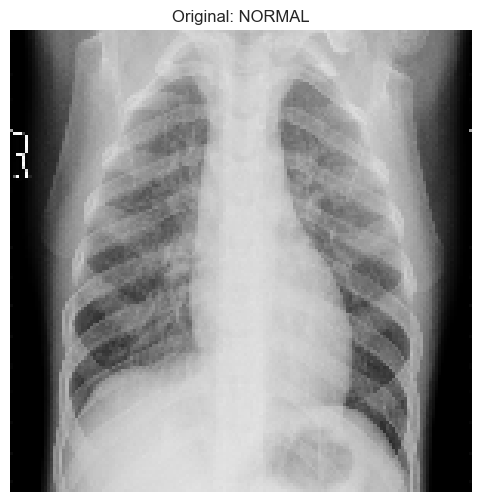

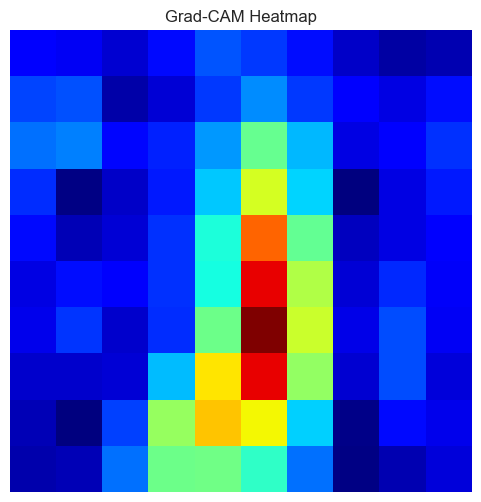

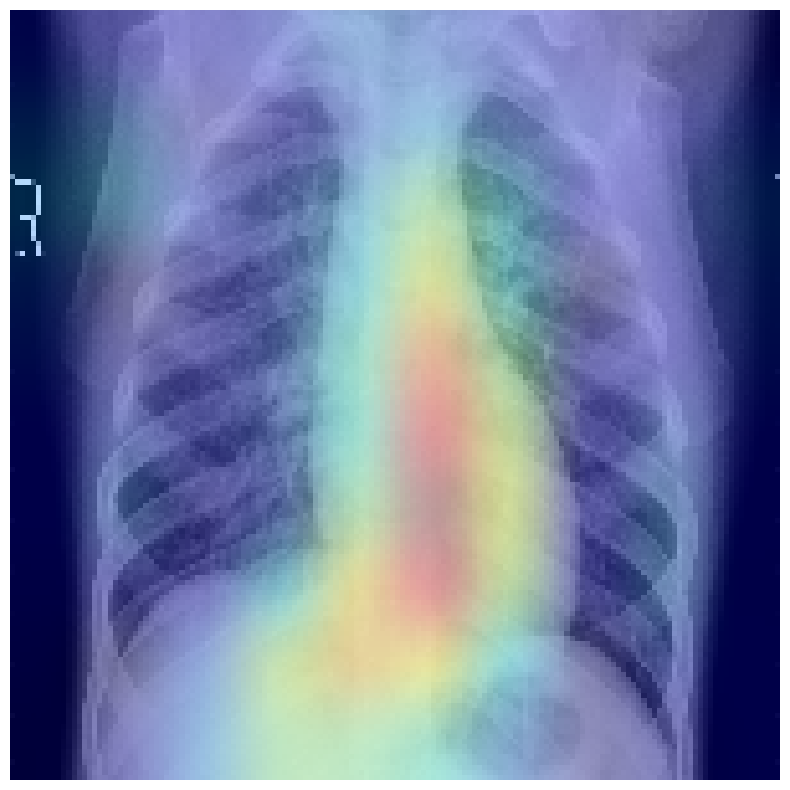


Sample 5:
True label: NORMAL
Predicted label: PNEUMONIA
Prediction confidence: 0.60


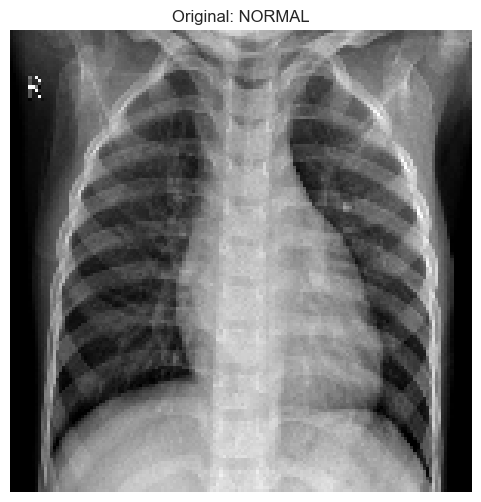

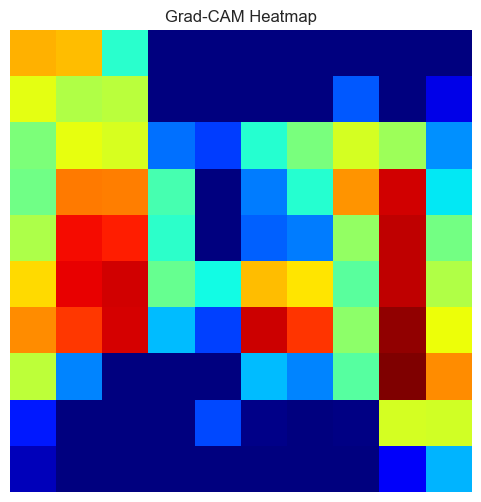

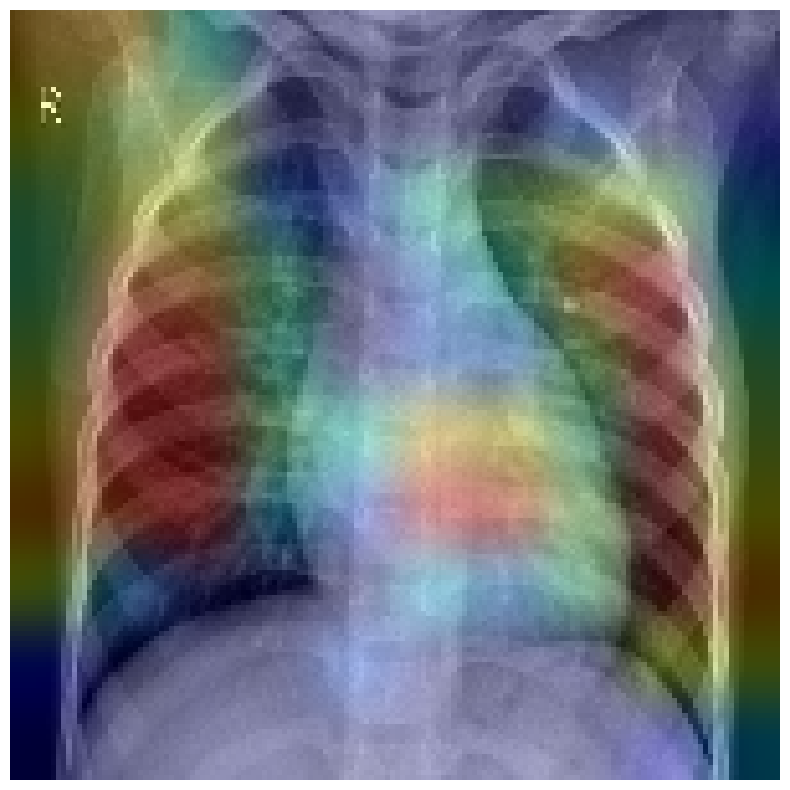

In [ ]:
# Generate Grad-CAM for each misclassified sample
for i, idx in enumerate(selected_indices):
    img_array = x_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]
    
    # Prepare image array (add batch dimension)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(
        img_array_expanded, 
        model, 
        last_conv_layer_name,
        pred_index=0  # Using 0 for binary classification
    )
    
    # Display results
    print(f"\nSample {i+1}:")
    print(f"True label: {labels[true_label]}")
    print(f"Predicted label: {labels[pred_label]}")
    print(f"Prediction confidence: {y_pred[idx][0]:.2f}")
    
    # Show original image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(img_array), cmap='gray')
    plt.title(f"Original: {labels[true_label]}")
    plt.axis('off')
    plt.show()
    
    # Show heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()
    
    # Show superimposed image
    save_and_display_gradcam(img_array, heatmap)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib

def make_vit_gradcam_heatmap(img_array, model, last_transformer_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for ViT models"""
    # Create model that maps input to last transformer layer + output predictions
    grad_model = keras.models.Model(
        model.inputs, 
        [model.get_layer(last_transformer_layer_name).output, model.output]
    )

    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        last_transformer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of output neuron with regard to last transformer output
    grads = tape.gradient(class_channel, last_transformer_output)

    # Pooled gradients (average over sequence length)
    pooled_grads = tf.reduce_mean(grads, axis=1)

    # Heatmap - weight the transformer outputs by gradients
    last_transformer_output = last_transformer_output[0]
    heatmap = last_transformer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0-1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_vit_gradcam(img_array, heatmap, patch_size=16, alpha=0.4):
    """Display Grad-CAM for ViT models with patch visualization"""
    img_size = img_array.shape[0]
    num_patches = img_size // patch_size
    
    # Convert grayscale to RGB for visualization
    img = np.uint8(255 * img_array)
    img = np.squeeze(img)  # Remove single-dimensional entries
    img = np.stack((img,)*3, axis=-1)  # Convert to RGB
    
    # Reshape heatmap to patch grid and resize to original image size
    patch_heatmap = heatmap.reshape((num_patches, num_patches))
    heatmap_resized = tf.image.resize(
        patch_heatmap[..., tf.newaxis], 
        (img_size, img_size),
        method='nearest'
    ).numpy().squeeze()
    
    # Rescale heatmap to 0-255
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Use jet colormap
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_resized]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_size, img_size))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    
    # Display Grad CAM
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# First, identify misclassified samples from the test set
y_pred = vit_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

misclassified_indices = np.where(y_pred_classes != y_test)[0]

# Select 5 random misclassified samples
np.random.seed(42)
selected_indices = np.random.choice(misclassified_indices, 5, replace=False)

# Get the last transformer layer name from your model
last_transformer_layer_name = "layer_normalization_19"  # Last layer norm before classification head

# Generate Grad-CAM for each misclassified sample
for i, idx in enumerate(selected_indices):
    img_array = x_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]
    
    # Prepare image array (add batch dimension)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    
    # Generate heatmap
    heatmap = make_vit_gradcam_heatmap(
        img_array_expanded, 
        vit_model, 
        last_transformer_layer_name,
        pred_index=pred_label
    )
    
    # Display results
    print(f"\nSample {i+1}:")
    print(f"True label: {labels[true_label]}")
    print(f"Predicted label: {labels[pred_label]}")
    print(f"Prediction confidence: {np.max(y_pred[idx]):.2f}")
    
    # Show original image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(img_array), cmap='gray')
    plt.title(f"Original: {labels[true_label]}")
    plt.axis('off')
    plt.show()
    
    # Show patch attention heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap.reshape(9, 9), cmap='jet')  # 150/16 ≈ 9 patches per dimension
    plt.title("Patch Attention Heatmap")
    plt.colorbar()
    plt.axis('off')
    plt.show()
    
    # Show superimposed image
    save_and_display_vit_gradcam(img_array, heatmap, patch_size=16)

20/20 [==============================] - 3s 98ms/step


ValueError: No such layer: layer_normalization_19. Existing layers are: ['input_4', 'tf.repeat_3', 'conv2d_6', 'reshape_1', 'tf.__operators__.add_1', 'layer_normalization_20', 'multi_head_attention_9', 'add_17', 'layer_normalization_21', 'dense_26', 'dropout_27', 'dense_27', 'dropout_28', 'add_18', 'layer_normalization_22', 'multi_head_attention_10', 'add_19', 'layer_normalization_23', 'dense_28', 'dropout_29', 'dense_29', 'dropout_30', 'add_20', 'layer_normalization_24', 'multi_head_attention_11', 'add_21', 'layer_normalization_25', 'dense_30', 'dropout_31', 'dense_31', 'dropout_32', 'add_22', 'layer_normalization_26', 'multi_head_attention_12', 'add_23', 'layer_normalization_27', 'dense_32', 'dropout_33', 'dense_33', 'dropout_34', 'add_24', 'layer_normalization_28', 'flatten_3', 'dropout_35', 'dense_34', 'dropout_36', 'dense_35', 'dropout_37', 'dense_36'].

## Report
- Task definition
- Data description (results of data exploration)
- Description of baseline method
- Desciption of hyperparameter optimization
- Results: A table for...
    - Baseline results (repication of exisiting method)
    - Results of hyperparameter optimization/alternative approach
    - Extensive analysis of best model using XAI techniques
- Brief conclusion: Which feature respresentation/model worked the best and why
<br>
Maximum 8 pages

## Submission
Submit report as pdf along with code zipfile in Brightspace